This notebook referred to the tutorial: https://www.tensorflow.org/tutorials/generative/cyclegan?hl=zh-cn

**1.Set the environment and packages**






Clone tensorflow_examples to my google drive in order to import pix2pix.

In [ ]:
#connect to my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/992gan
!ls

/content/gdrive/MyDrive/992gan
 checkpoints
'Copy of 01DCGAN-手写数字图像生成.ipynb'
 examples
'我的最终Pytorch Wasserstein GAN.ipynb'


In [ ]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23066, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 23066 (delta 6), reused 7 (delta 0), pack-reused 23038
Receiving objects: 100% (23066/23066), 42.17 MiB | 19.87 MiB/s, done.
Resolving deltas: 100% (12655/12655), done.


In [ ]:
import os, sys

In [ ]:
os.getcwd()

'/content/gdrive/MyDrive/992gan/examples'

For the second time, run the code from this point.

In [ ]:
#connect to my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#change directory
%cd /content/gdrive/MyDrive/992gan/examples

/content/gdrive/MyDrive/992gan/examples


In [ ]:
!ls

AUTHORS		 courses      lite	   setup.py
CODEOWNERS	 __init__.py  __pycache__  templates
CONTRIBUTING.md  LICENSE      README.md    tensorflow_examples


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
#use for training data
import pathlib
from PIL import Image

**2.Check training data**

> Content
vangogh2photo dataset consists of 800 Monet Paintings & 7038 Natural Photos with each split into train and test subsets.

> 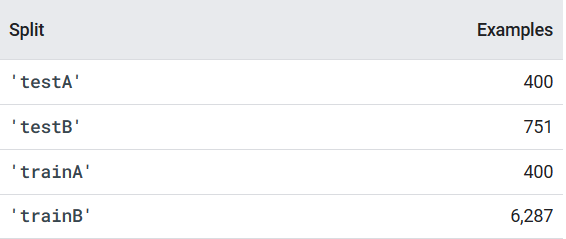

> This dataset was obtained from UC Berkeley's official directory of CycleGAN Datasets.




https://www.kaggle.com/code/nurullahyksel/monet2photo-cyclegan-with-keras/input

https://github.com/xiaowei-hu/CycleGAN-tensorflow

3.Create data pipeline

In [ ]:
dataset, metadata = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)

train_photos, train_draws = dataset['trainB'], dataset['trainA']
test_photos, test_draws = dataset['testB'], dataset['testA']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKXDJF3/cycle_gan-trainB.tfrecord*.…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKXDJF3/cycle_gan-testA.tfrecord*..…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteKXDJF3/cycle_gan-testB.tfrecord*..…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0. Subsequent calls will reuse this data.


4.Random dithering and mirroring

As described in the paper, random dithering and mirroring are applied to the training set. These are some image enhancement techniques that avoid over fitting.

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_photos = train_photos.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_draws = train_draws.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photos = test_photos.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_draws = test_draws.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_photos = next(iter(train_photos))
sample_draws = next(iter(train_draws))

In [ ]:
#sample_photos[0]

In [ ]:
#sample_photos[0] * 0.5 + 0.5

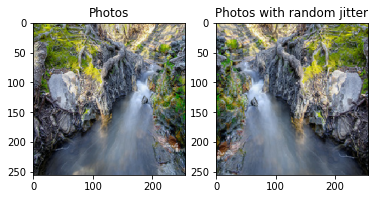

In [ ]:
plt.subplot(121)
plt.title('Photos')
plt.imshow(sample_photos[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photos with random jitter')
plt.imshow(random_jitter(sample_photos[0]) * 0.5 + 0.5)

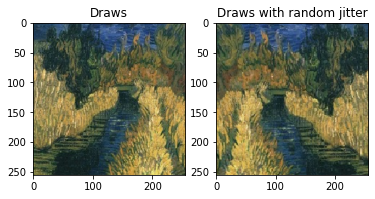

In [ ]:
plt.subplot(121)
plt.title('Draws')
plt.imshow(sample_draws[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Draws with random jitter')
plt.imshow(random_jitter(sample_draws[0]) * 0.5 + 0.5)

5.Import and reuse the Pix2Pix model

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

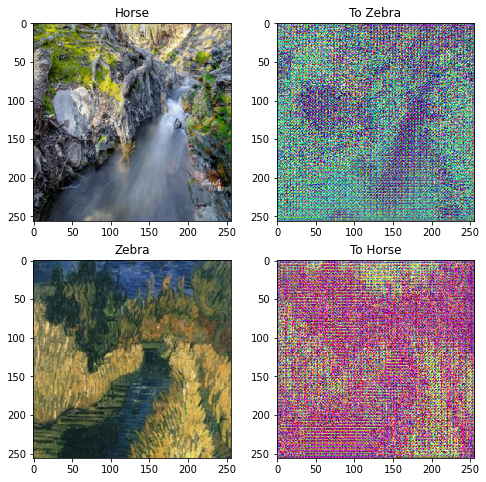

In [ ]:
to_zebra = generator_g(sample_photos)
to_horse = generator_f(sample_draws)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photos, to_zebra, sample_draws, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

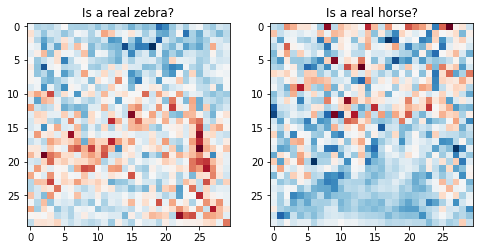

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_draws)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_photos)[0, ..., -1], cmap='RdBu_r')

plt.show()

***6.Loss function***

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**7.Checkpoints**

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

**8.Training**

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

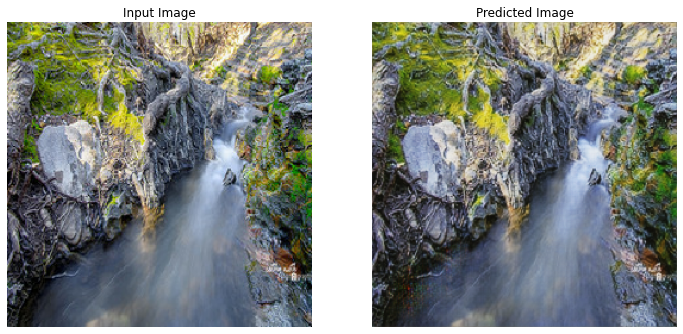

Time taken for epoch 38 is 171.7620553970337 sec

............

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_photos, train_draws)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # 使用一致的图像（sample_photos），以便模型的进度清晰可见。
  generate_images(generator_g, sample_photos)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

9.Generate images using test datasets

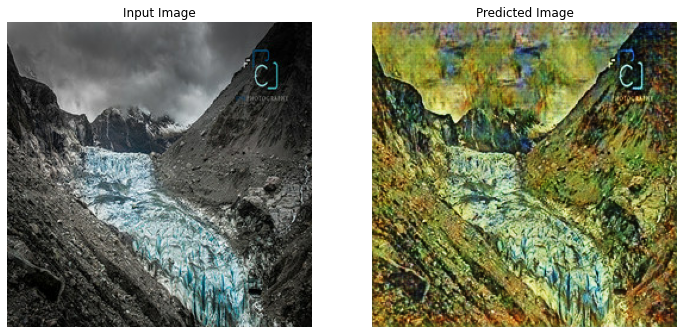

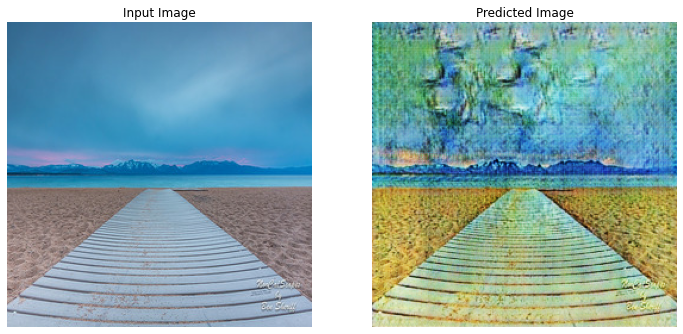

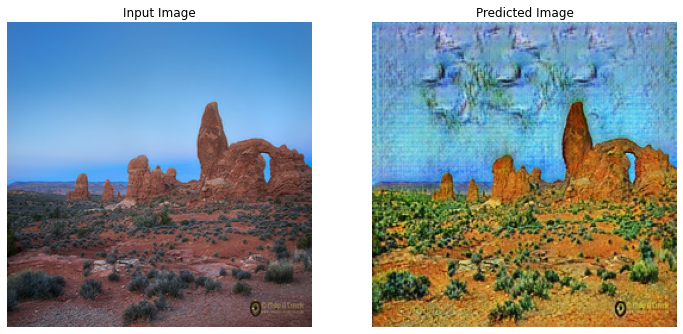

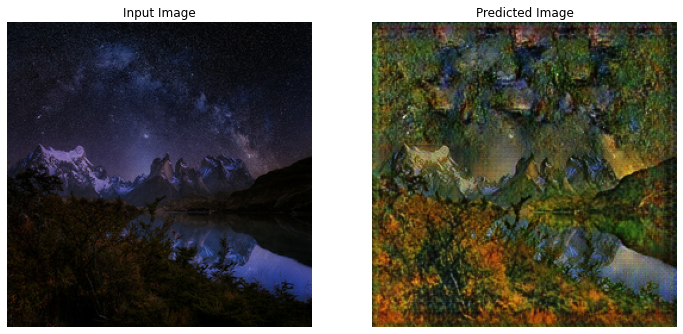

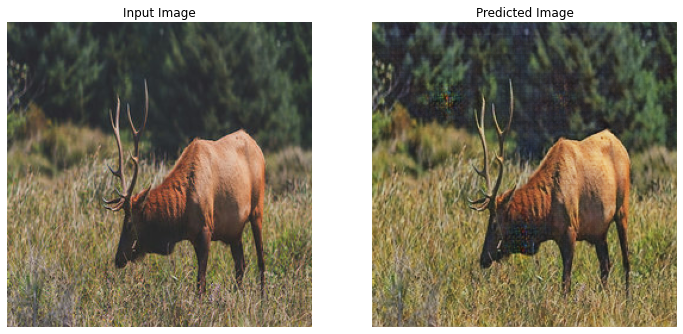

In [ ]:
# Run the trained model on the test dataset
for inp in test_photos.take(5):
  generate_images(generator_g, inp)

10. Change the style of my own images

In [ ]:
def load_and_preprocess_image(image_path, img_width, img_height):
    img = Image.open(image_path)
    img = img.resize((img_width, img_height), Image.ANTIALIAS)
    img = np.array(img) / 255.0
    return img

In [ ]:
image_path = '/content/gdrive/MyDrive/992gan/person.jpg'
img_width, img_height = 256, 256  # You can set the desired dimensions

image = load_and_preprocess_image(image_path, img_width, img_height)


In [ ]:
#Convert the preprocessed image(s) to a TensorFlow dataset:
test_photo_data = tf.data.Dataset.from_tensor_slices([image])


In [ ]:
# normalizing the images to [-1, 1]
def normalize_my_own(image):
  #image = tf.cast(image, tf.float32)
  image = (image-0.5)*2
  return image

In [ ]:
def preprocess_image_test_my_own(image):
  image = normalize_my_own(image)
  return image

In [ ]:
test_photo_data = test_photo_data.map(
    preprocess_image_test_my_own, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

#test_draws = test_draws.map(
    #preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    #BUFFER_SIZE).batch(BATCH_SIZE)

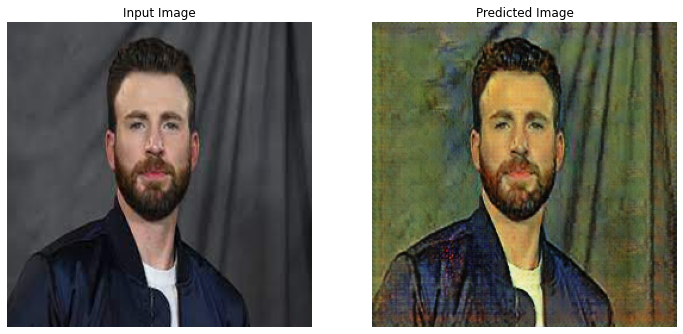

In [ ]:
for ele in test_photo_data.take(1):
  generate_images(generator_g, ele)